### Quickstart Guides
#### Tutorial: AI Observability for RAG using Cortex Search and Cortex LLMs
This tutorial will show you how to use AI observability with Snowflake on a RAG application built
using [Cortex Search](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-search/cortex-search-overview) and LLMs using [Cortex Complete function](https://docs.snowflake.com/en/sql-reference/functions/complete-snowflake-cortex) . Before adding observability,
you will need to create an application to observe. To do so, start with [Cortex Search Tutorial 3](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-search/tutorials/cortex-search-tutorial-3-chat-advanced),
completing through step 4. Once you have created the cortex search service following the
tutorial, return here to finish building the RAG and add observability.

**Introduction**

This tutorial describes how to add observability to a simple RAG application.
**What you will learn**

- Add observability to a RAG application built with Cortex Search & Cortex & LLMs
- Compute evaluation metrics using Cortex LLMs running in the warehouse
- Log evaluation metrics and traces to Snowflake

**Prerequisites**

The following prerequisites are required to complete this tutorial:

- You have a Snowflake account and user with a role that grants the necessary privileges
to create a database, tables, virtual warehouse objects, Cortex Search services, call
Cortex LLMs and use Snowflake Notebooks. Refer to the [Snowflake in 20 minutes](https://docs.snowflake.com/en/user-guide/tutorials/snowflake-in-20minutes) for
instructions to meet these requirements.

- You have already created a Cortex Search Service using [Cortex Search Tutorial 3](https://docs.snowflake.com/en/user-guide/snowflake-cortex/cortex-search/tutorials/cortex-search-tutorial-3-chat-advanced).

**Step 1: Setup**

1. Create a new schema in the Cortex Search Tutorial Database created in the prerequisites.

SQL
```
USE CORTEX_SEARCH_TUTORIAL_DB;
CREATE OR REPLACE SCHEMA AI_OBSERVABILITY_SCHEMA;
```
This creates a new schema to store the traces and evaluation results needed for observability.

2. Create a Snowflake notebook using `CORTEX_SEARCH_TUTORIAL_DB` database,
`AI_OBSERVABILITY_SCHEMA`, and `CORTEX_SEARCH_TUTORIAL_WH` warehouse.
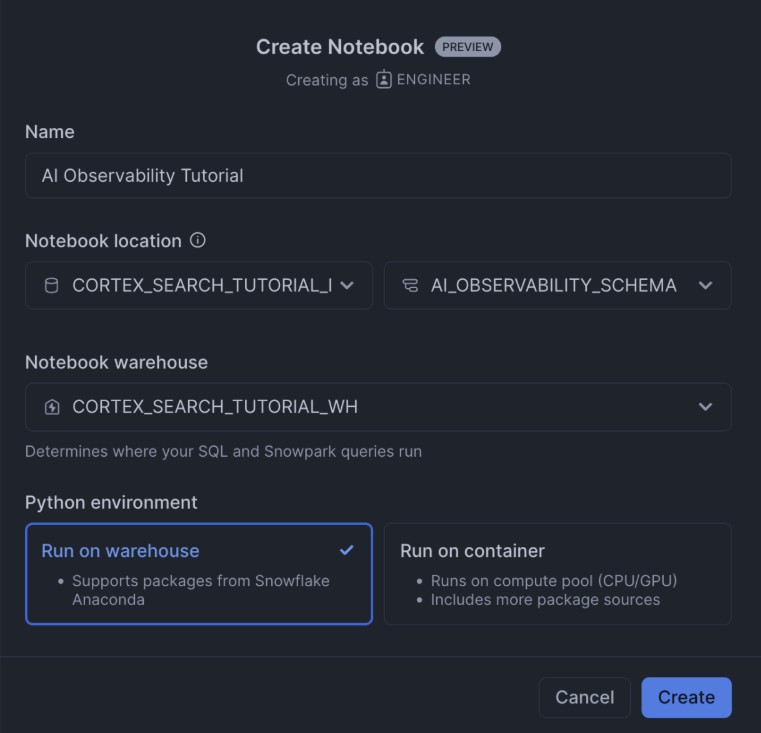

3. Add the following Trulens and Snowflake ML python packages to the snowflake notebook.

- `trulens-core`
- `trulens-feedback`
- `trulens-connectors-snowflake`
- `trulens-providers-cortex`
- `snowflake-ml-python`

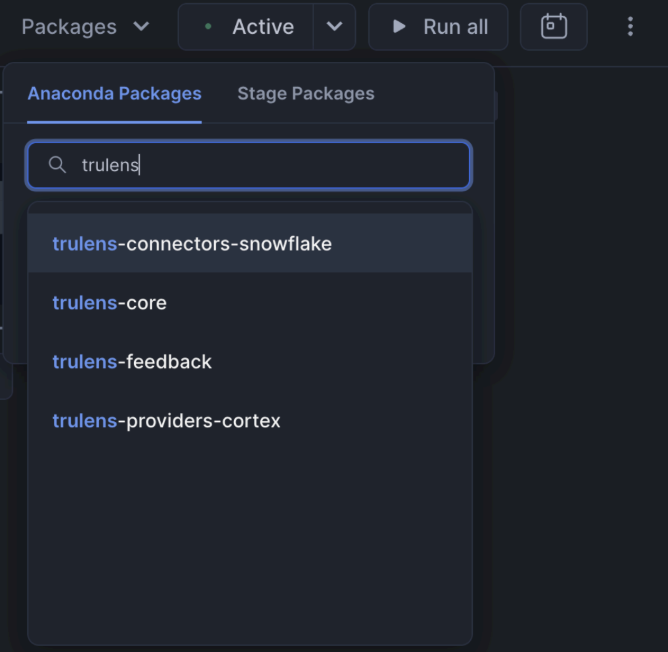

**Step 2: Set up RAG application and add instrumentation for tracing**


Now that we've set up the components we need from Snowflake Cortex, we can build our RAG.
We'll do this by creating a custom python class with methods for retrieval generation and chaining.
We'll also add TruLens instrumentation with the `@instrument` decorator to each method in our app
we’d like to record.
The first thing we need to do is to set the database connection to Snowflake where we'll log the
traces and evaluation results from our application. Since we’re already working in a Snowflake
notebook, we’ll do this by creating a connector for TruLens to Snowflake with the active Snowpark
Session.

### This example quickstart is assumed to be run within Snowflake notebook runtime

In [ ]:
from snowflake.snowpark.context import get_active_session
from trulens.connectors.snowflake import SnowflakeConnector
from trulens.core import TruSession

# Get Snowflake session
snowpark_session = get_active_session()

# Create database connection
tru_snowflake_connector = SnowflakeConnector(snowpark_session=snowpark_session)
tru_session = TruSession(connector=tru_snowflake_connector)

In [ ]:
from typing import List

from snowflake.core import Root
from snowflake.cortex import Complete
from snowflake.snowpark.context import get_active_session
from trulens.apps.custom import instrument


# Create RAG application with Cortex Search and Cortex Complete function
class RAG:
    def __init__(self, database, schema, search_service, limit_to_retrieve):
        self.database = database
        self.schema = schema
        self.search_service = search_service
        self.limit_to_retrieve = limit_to_retrieve
        self.session = get_active_session()
        self.session.use_schema(schema)
        svc_search_col = self.session.sql(
            f"DESC CORTEX SEARCH SERVICE {search_service};"
        ).collect()[0]["search_column"]
        service_metadata = {
            "name": search_service,
            "search_column": svc_search_col,
        }
        self.service_metadata = service_metadata

    @instrument
    def retrieve(self, query: str) -> List[str]:
        cortex_search_service = (
            Root(self.session)
            .databases[self.database]
            .schemas[self.schema]
            .cortex_search_services[self.search_service]
        )
        context_documents = cortex_search_service.search(
            query,
            columns=[self.service_metadata["search_column"]],
            limit=self.limit_to_retrieve,
        )
        return context_documents.results

    @instrument
    def generate_completion(self, query: str, context_documents: list) -> str:
        """
        Generate answer from context.
        """
        prompt = f"""
        You are an expert assistant extracting information from context
    provided.
        Answer the question based on the context. Be concise and do not
    hallucinate.
        If you don ́t have the information just say so.
        Context: {context_documents}
        Question:
        {query}
    Answer: """
        return Complete("mistral-large2", prompt)

    def query(self, query: str) -> str:
        context_str = self.retrieve(query)
        return self.generate_completion(query, context_str)


rag = RAG(
    database="CORTEX_SEARCH_TUTORIAL_DB",
    schema="PUBLIC",
    search_service="FOMC_MEETING",
    limit_to_retrieve=4,
)

In [ ]:
import numpy as np
from trulens.core import Feedback
from trulens.core import Select
from trulens.providers.cortex.provider import Cortex

provider = Cortex(snowpark_session, "llama3.1-8b")
f_context_relevance = (
    Feedback(provider.context_relevance, name="Context Relevance")
    .on(Select.RecordCalls.retrieve.args.query)
    .on(Select.RecordCalls.retrieve.rets.collect())
    .aggregate(np.mean)
)
f_answer_relevance = (
    Feedback(provider.relevance, name="Answer Relevance")
    .on(Select.RecordCalls.retrieve.args.query)
    .on_output()
    .aggregate(np.mean)
)
# For Snowflake notebook, sentence tokenizer needs to be set to false for groundedness evaluation.
f_groundedness = (
    Feedback(
        lambda source,
        statement: provider.groundedness_measure_with_cot_reasons(
            source=source, statement=statement, use_sent_tokenize=False
        ),
        name="Groundedness",
    )
    .on(Select.RecordCalls.retrieve.rets[:].collect())
    .on_output()
)

In [ ]:
from trulens.apps.custom import TruCustomApp

tru_rag = TruCustomApp(
    rag,
    app_name="RAG",
    app_version="simple",
    feedbacks=[f_answer_relevance, f_context_relevance],
    # feedbacks=[f_groundedness, f_answer_relevance, f_context_relevance],
)

In [ ]:
prompts = [
    "What was GDP Growth in 2024 Q3",
    "What was Janet Yellen's opinion on the growth outlook for 2025?",
]
with tru_rag as recording:
    for prompt in prompts:
        rag.query(prompt)